In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.typing as npt
import torch
import pyro
import pyro.distributions as dist
from src.models.paths import PROJECT_ROOT
from src.models.solid_earth_utils import compute_love_numbers, greens_function
print(PROJECT_ROOT)

/mnt/c/Users/dnjllg/OneDrive - Danmarks Tekniske Universitet/Dokumenter/PhD/Courses/Model-based Machine Learning/premis


In [4]:
station_coordinates = [68.58700000, -33.05270000]
glacier_coordinates = [68.645056, -33.029416]
hlove, nlove = compute_love_numbers()
gf = greens_function(hlove, nlove, glacier_coordinates, station_coordinates, arsurf=5e3 * 5e3)
print(gf)

['./e-clovers_3e_bench_TEMPLATE.sh', 'v3.5.6_Lin64S']
 +++++++++++++++++++++++++++++++++++++++++++++++
  Elastic - C L 0 V 3 R S
            Compressible L0Ve numb3Rs Solver
 +++++++++++++++++++++++++++++++++++++++++++++++
 * -------------------------------------------
 *   E-CL0V3RS v3.5.6 created by 
 *   A. Bordoni and V.R. Barletta - 2012
 * -------------------------------------------
 *   Earth model: earth_M3L70V01c.txt
 *   Compressibility: Yes 
 *   Label for outputs: Bench_C_256_O_2
 *   ReUse:            0
 *   Label for ReUse files: TestOutCompM_M
 *   ReUseLayer:            2
 *   LLN for layer:            1
 *   Execution Parameters:
 *       Boost =    0.00000000    
 *     MaxPrec =    1.00000001E-10
 *   ThreshMin =    1.00000003E-22
 *   Size of the Reals (in byte): SizeOf not available
 *   Starting degree:            0
  Reading the Earth parameters ...
  Number of layers detected:            5
  
  Processing love numbers ...
        4/  25        7/  25        1/ 

In [11]:
df_kuaq = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "KUAQ_filtered.csv")
df_mass = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "mass_time_series.csv")

In [6]:
t_up = df_kuaq.Time.values
up = df_kuaq.Up.values

mass = df_mass.mass.values
t_mass = df_mass.time.values

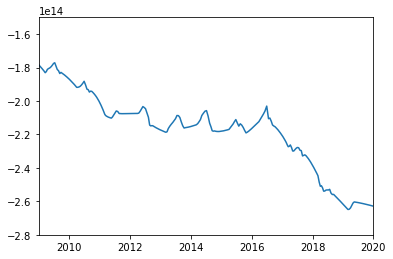

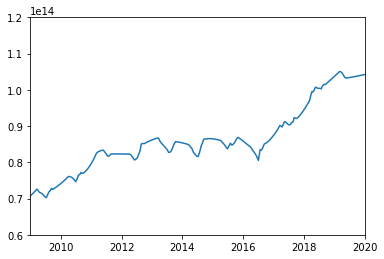

In [8]:
mass_to_height = mass / (1000 * (10e3 * 10e3)) / 365.25
dmass = mass - mass[0]

plt.plot(t_mass, dmass)
plt.xlim([2009, 2020])
plt.ylim([-2.8e14, -1.5e14])
plt.show()

plt.plot(t_mass, gf * dmass)
plt.xlim([2009, 2020])
plt.ylim([6e13, 1.2e14])
plt.show()

# Train_model.py

def premis_train(m, x=1, n=128, obs=None) -> np.ndarray:
    """Probabilistic model for uplift rates. This is the main model.
    Args:
        m (np.ndarray): mass time-series data
        s (int, optional): number of stations. Defaults to 2.
        n (int, optional): spherical harmonic degree. Defaults to 128.
        obs (_type_, optional): observed gnss station uplift rates. Defaults to None.

    Returns:
        np.ndarray: predicted uplift
    """

    #  could add dists over mu and sigmas
    #  sigma = pyro.sample("sigma", dist.HalfCauchy(5.))

    # Draw lithospheric elasticity
    E_L = pyro.sample("E_L", dist.Normal(0.0, 1.0))

    # Draw upper mantle elasticity
    E_UM = pyro.sample("E_UM", dist.Normal(0.0, 1.0))

    # Draw lower mantle elasticity
    E_LM = pyro.sample("E_LM", dist.Normal(0.0, 1.0))

    # Draw mass change with time
    # m = pyro.sample("m", dist.Normal(torch.zeros(128), torch.ones(128)))

    sigma_w = pyro.sample("sigma", dist.HalfCauchy(0.1))
    sigma_gf = 1

    station_coordinates = [68.58700000, -33.05270000]  # [lat, lon]
    glacier_coordinates = [68.645056, -33.029416]  # [lat, lon]

    with pyro.plate("data"):
        # Draw Love Numbers
        hlove, nlove = torch.tensor(compute_love_numbers())

        # Draw Greens Function
        gf = pyro.sample(
            "gf",
            dist.Normal(
                greens_function(hlove, nlove, glacier_coordinates, station_coordinates),
                sigma_gf,
            ),
        )

        # Draw target
        w = pyro.sample("w", dist.Normal(gf * m, sigma_w), obs=obs)

    return w


def taboo(j: int, e_l: float, e_um: float, e_lm: float) -> np.ndarray:
    """temporary taboo function for running pyro model
    Args:
        j (int): _description_
        e_l (float): _description_
        e_um (float): _description_
        e_lm (float): _description_

    Returns:
        np.ndarray: _description_
    """

    love_numbers = np.random.randint(j)
    return love_numbers


# if __name__ == '__main__':
#     # X = load data
#     # obs = ob
#     _ = premis_train()
